In [62]:
import pandas as pd 
import numpy as np 
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from skimpy import skim
import statsmodels.api as sm

In [63]:
df=pd.read_csv('../datasets/d5.csv')

In [64]:
def zscore(s, window, thresh=1, return_all=False):
    roll = s.rolling(window=window, min_periods=1, center=True)
    avg = roll.mean()
    std = roll.std(ddof=0)
    z = s.sub(avg).div(std)
    m = z.between(-thresh, thresh)
    
    if return_all:
        return z, avg, std, m
    return s.where(m, avg)

df['Cleaned Energy Consumption'] = zscore(df['Energy Consumption'], window=7)
df = df[['Date', 'Cleaned Energy Consumption']]
df.rename(columns={'Cleaned Energy Consumption': 'Energy Consumption'}, inplace=True)



In [65]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df['Energy Consumption'].values.reshape(-1, 1))


In [66]:
lookback = 15
X, y = [], []
for i in range(len(data) - lookback):
    X.append(data[i:i + lookback])
    y.append(data[i + lookback])

X, y = np.array(X), np.array(y)

# Reshape X to be compatible with CNN (samples, channels, features)
X = X.reshape(X.shape[0], 1, X.shape[1])  # Add channel dimension
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y)

In [67]:
split = int(len(X_tensor) * 0.8)
X_train, X_test = X_tensor[:split], X_tensor[split:]
y_train, y_test = y_tensor[:split], y_tensor[split:]

In [68]:
val_split = int(len(X_train) * 0.2)  # Use 20% of the training set for validation
X_val, X_train = X_train[:val_split], X_train[val_split:]
y_val, y_train = y_train[:val_split], y_train[val_split:]

In [69]:
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3)
        self.fc1 = nn.Linear(32 * (lookback - 4), 64)  # Adjust input size based on conv output
        self.fc2 = nn.Linear(64, 1)
    
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the output
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [70]:
model = CNN1D()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([925, 1])) that is different to the input size (torch.Size([925])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([231, 1])) that is different to the input size (torch.Size([231])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Train Loss: 0.0631, Validation Loss: 0.0154
Epoch [20/100], Train Loss: 0.0391, Validation Loss: 0.0319
Epoch [30/100], Train Loss: 0.0397, Validation Loss: 0.0759
Epoch [40/100], Train Loss: 0.0373, Validation Loss: 0.0786
Epoch [50/100], Train Loss: 0.0372, Validation Loss: 0.0658
Epoch [60/100], Train Loss: 0.0372, Validation Loss: 0.0621
Epoch [70/100], Train Loss: 0.0371, Validation Loss: 0.0629
Epoch [80/100], Train Loss: 0.0371, Validation Loss: 0.0644
Epoch [90/100], Train Loss: 0.0371, Validation Loss: 0.0654
Epoch [100/100], Train Loss: 0.0371, Validation Loss: 0.0659
Mean Squared Error: 0.1027
R-squared: -10.9665


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([289, 1])) that is different to the input size (torch.Size([289])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


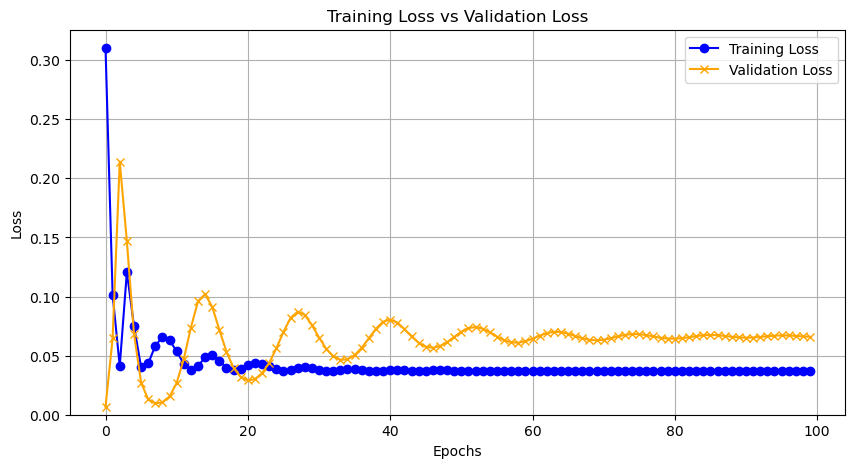

In [71]:
train_losses = []
val_losses = []

# Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Zero the gradients

    # Forward pass on training data
    outputs = model(X_train)
    loss = criterion(outputs.squeeze(), y_train)  # Compute training loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Store training loss
    train_losses.append(loss.item())

    # Validation
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs.squeeze(), y_val)  # Compute validation loss
        val_losses.append(val_loss.item())  # Store validation loss

    # Print losses every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

# Evaluation on test data
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    mse = criterion(predictions.squeeze(), y_test)
    r_squared = 1 - (mse.item() / torch.var(y_test).item())

# Display results
print(f'Mean Squared Error: {mse.item():.4f}')
print(f'R-squared: {r_squared:.4f}')

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue', marker='o')  # Blue line for training loss
plt.plot(val_losses, label='Validation Loss', color='orange', marker='x')  # Orange line for validation loss
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.ylim(bottom=0)  # Optionally set the bottom limit for y-axis to 0 for better visualization
plt.show()